<a href="https://colab.research.google.com/github/rselent/lambda-buildweek2-asteroids/blob/master/build2_Asteroids_predicting_PHAs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Checking GPU status / existence

!nvidia-smi

Thu Jan  9 19:32:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# I don't know how replicable this is per user, but for now this should let me
# access my CSV, which is stored on Google Drive instead of github due to size
# (currently >100mb, maybe less after it's cleaned)

# If I perchance get it under 100mb, I'll migrate it over to github, but that
# won't be a primary (nor secondary) objective

from google.colab import drive
drive.mount( '/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install catboost
    !pip install ipywidgets
    !pip install lightgbm --install-option=--gpu        # Alternative to catboost, maybe?

In [4]:
import pandas as pd
import numpy as np

# New dataset, self-generated from JPL Small-Body Database Search Engine, 1/6/2020, 5:10pm
df = pd.read_csv( 'drive/My Drive/Colab Notebooks/Lambda School DS/Unit 2/Build Data/Asteroids_2020.csv', low_memory= False)
# Original dataset, found on Kaggle, generated from same source (JPL) but by a 3rd party, unknown date
df_old = pd.read_csv( 'drive/My Drive/Colab Notebooks/Lambda School DS/Unit 2/Build Data/Asteroid.csv', low_memory= False)

# df_old will be deprecated by week's end to reduce end filesize, but keeping for now (along with appropriate notations) to show process
df_old.shape, df.shape

((839714, 31), (921901, 34))

In [0]:
# I pulled the same datapoints / features from the original set, changed 1 (name -> full_name), and added 3 more:
# pdes - primary designation (more complete name list, presumably/just-in-case),
# and H_sigma and diameter_sigma - 1-sigma uncertainty values
# It seems ~80k more objects had been identified since the Kaggle set was generated and mine, also :o

df.head(20)

,full_name,pdes,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,H_sigma,neo,pha,diameter,diameter_sigma,extent,albedo,rot_per,GM,BV,UB,IR,spec_B,spec_T,G,moid,class,n,per,ma
0,1 Ceres,1,2.769165,0.076009,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,8822.0,0,1002,3.34,NaN,N,N,939.4,0.200,964.4 x 964.2 x 891.8,0.0900,9.074170,62.6284,0.713,0.426,NaN,C,G,0.12,1.594780,MBA,0.213885,1683.145708,77.372096
1,2 Pallas,2,2.772466,0.230337,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,72318.0,0,8490,4.13,NaN,N,N,545,18.000,582x556x500,0.1010,7.813200,14.3000,0.635,0.284,NaN,B,B,0.11,1.233240,MBA,0.213503,1686.155999,59.699133
2,3 Juno,3,2.669150,0.256942,12.988918,169.852756,248.138627,1.983332,3.354967,4.360814,72901.0,0,7109,5.33,NaN,N,N,246.596,10.594,NaN,0.2140,7.210000,NaN,0.824,0.433,NaN,Sk,S,0.32,1.034540,MBA,0.226019,1592.787286,34.925016
3,4 Vesta,4,2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,24288.0,0,9325,3.20,NaN,N,N,525.4,0.200,572.6 x 557.2 x 446.4,0.4228,5.342128,17.8000,0.782,0.492,NaN,V,V,0.32,1.139480,MBA,0.271609,1325.432765,95.861936
4,5 Astraea,5,2.574249,0.191095,5.366988,141.576605,358.687607,2.082324,3.066174,4.130323,63519.0,0,2926,6.85,NaN,N,N,106.699,3.140,NaN,0.2740,16.806000,NaN,0.826,0.411,NaN,S,S,NaN,1.095890,MBA,0.238632,1508.600458,282.366289
5,6 Hebe,6,2.425160,0.203007,14.737901,138.640203,239.807490,1.932835,2.917485,3.776755,62329.0,0,6034,5.71,NaN,N,N,185.18,2.900,NaN,0.2679,7.274500,NaN,0.822,0.399,NaN,S,S,0.24,0.973965,MBA,0.260972,1379.459705,86.197923
6,7 Iris,7,2.385334,0.231206,5.523651,259.563231,145.265106,1.833831,2.936837,3.684105,62452.0,0,5206,5.51,NaN,N,N,199.83,10.000,NaN,0.2766,7.139000,NaN,0.855,0.484,NaN,S,S,NaN,0.846100,MBA,0.267535,1345.619196,140.419656
7,8 Flora,8,2.201764,0.156499,5.886955,110.889330,285.287462,1.857190,2.546339,3.267115,62655.0,0,2744,6.49,NaN,N,N,147.491,1.025,NaN,0.2260,12.865000,NaN,0.885,0.489,NaN,NaN,S,0.28,0.874176,MBA,0.301681,1193.313717,194.882895
8,9 Metis,9,2.385637,0.123114,5.576816,68.908577,6.417369,2.091931,2.679342,3.684806,61821.0,0,2649,6.28,NaN,N,N,190,NaN,NaN,0.1180,5.079000,NaN,0.858,0.496,NaN,NaN,S,0.17,1.106910,MBA,0.267484,1345.875362,276.861623
9,10 Hygiea,10,3.141539,0.112461,3.831560,283.202165,312.315210,2.788240,3.494839,5.568291,62282.0,0,3442,5.43,NaN,N,N,407.12,6.800,NaN,0.0717,27.630000,7.0000,0.696,0.351,NaN,C,C,NaN,1.778390,MBA,0.177007,2033.818281,152.184851


In [0]:
df.isnull().sum()

full_name              0
pdes                   0
a                      0
e                      0
i                      0
om                     0
w                      0
q                      0
ad                     5
per_y                  1
data_arc           38811
condition_code       901
n_obs_used             0
H                   2323
H_sigma           734362
neo                    5
pha                39715
diameter          784793
diameter_sigma    784921
extent            921883
albedo            785978
rot_per           903105
GM                921887
BV                920880
UB                920922
IR                921900
spec_B            920235
spec_T            920921
G                 921782
moid               39715
class                  0
n                      0
per                    5
ma                     1
dtype: int64

In [0]:
# Sigma features, while showing interesting/more precise data (or just precision
# metrics?), do not seem to be worth pursuing re: my objective. There are too many
# missing values in 'H_sigma', for example. 
# The delta between 'diameter' and 'diameter_sigma' is not all that large, however,
# so that could be an interesting secondary or perhaps tertiary objective.

# That said, right off the bat I will be dropping all features with more than 50%
# nan values, as not only is that just straight prohibitive to making any sort of 
# predictions of value, they also, coincidentally, happen to be the most 
# inconsequential features of the dataset (for my needs, and from my knowledge)

In [5]:
df1 = df.drop( columns= {'full_name', 'pdes', 'data_arc', 'H_sigma', 'diameter',
                         'diameter_sigma', 'extent', 'albedo', 'rot_per',
                         'GM', 'BV', 'UB', 'IR', 'spec_B', 'spec_T', 'G'})
df1.shape

(921901, 18)

In [0]:
df1.head()

,a,e,i,om,w,q,ad,per_y,condition_code,n_obs_used,H,neo,pha,moid,class,n,per,ma
0,2.769165,0.076009,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,0,1002,3.34,N,N,1.59478,MBA,0.213885,1683.145708,77.372096
1,2.772466,0.230337,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,0,8490,4.13,N,N,1.23324,MBA,0.213503,1686.155999,59.699133
2,2.669150,0.256942,12.988918,169.852756,248.138627,1.983332,3.354967,4.360814,0,7109,5.33,N,N,1.03454,MBA,0.226019,1592.787286,34.925016
3,2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,0,9325,3.20,N,N,1.13948,MBA,0.271609,1325.432765,95.861936
4,2.574249,0.191095,5.366988,141.576605,358.687607,2.082324,3.066174,4.130323,0,2926,6.85,N,N,1.09589,MBA,0.238632,1508.600458,282.366289


In [0]:
df1.isnull().sum()

a                     0
e                     0
i                     0
om                    0
w                     0
q                     0
ad                    5
per_y                 1
condition_code      901
n_obs_used            0
H                  2323
neo                   5
pha               39715
moid              39715
class                 0
n                     0
per                   5
ma                    1
dtype: int64

In [0]:
# TODO: Everything?

# TODO2: Do 'pha' and 'moid' share the same Nans? <investigate>

# TODO3: Maybe split those observations, make them an ultimate test/prediction case? Or at least part of? Will that work?

# TODO4: I don't want to impute any of these Nan values; is there an algorithm/model that can accommodate? LightGBM? CatBoost?

# TODO5: <todo>

In [0]:
# Testing whether 'pha' contains the same NaN elements as 'moid':

dfTest1 = df1[[ 'a', 'e', 'pha']]
dfTest2 = df1[[ 'a', 'e', 'moid']]

dfTest1[ dfTest1.isnull().any(axis=1)].equals( dfTest2[dfTest2.isnull().any(axis=1)] )

False

In [0]:
# Sooo, they're not the same. Ok. What now... <TODO2 complete>

## HOWEVER, when I pull the 'pha' NaNs out of the df, all the 'moid' NaNs disappear
## in a .isnull().sum() inspection o.O

## Either way....

In [0]:
###  Train / Test / Validation splitting  ###

# Splitting 'pha' NaNs away first, planning on using as ultimate prediction case, maybe?
# <TODO3 complete>
phaNans = df1[ df1['pha'].isnull()]
df1 = df1[ df1['pha'].notnull()]

###     IMPORTANT     ###
##  only ~2k observations left with NaN values in potentially crucial features (below).
##  I don't _want_ to drop those asteroids from the dataset, because __ALL IT TAKES IS ONE__
##  BUT... if they cause too many complications, I will come back and drop them.
##  Just un-comment and run:
df2 = df1.dropna().copy()

##  2 HOURS LATER: Uncommenting, for sake of sanity. 
##      It's only a project / "for fun" after all, right? 
##                      RIGHT??? D: lol

## 1 HOUR AFTER THAT: Recommenting. It didn't solve the problem that 
##      I thought it would. So un-pressing the Big Red Button... for now...
##

## LAST UPDATE ON THIS: f it. pushing the button for good. Leaving df1 for data 
##                      preservation, temporarily, will clean up once work is done
##                      and notebook is pushed live

In [0]:
df1.isnull().sum()          # pre-.dropna()

a                    0
e                    0
i                    0
om                   0
w                    0
q                    0
ad                   5
per_y                1
condition_code      15
n_obs_used           0
H                 2322
neo                  5
pha                  0
moid                 0
class                0
n                    0
per                  5
ma                   1
dtype: int64

In [0]:
#####       BASELINE       #####
## (post NaN purge, pre .dropna() purge)

## Leaving this here for posterity and comparison's sake for now

print( df1['pha'].value_counts())
print( df1['pha'].value_counts( normalize= True) * 100)     # *100 for % 

N    880160
Y      2026
Name: pha, dtype: int64
N    99.770343
Y     0.229657
Name: pha, dtype: float64


Baseline **Accuracy** is about 1/4th of a percent (0.23%), which means accuracy is basically meaningless for this, and I need to look at a more appropriate metric, like Recall, perhaps

In [0]:
#####       BASELINE       #####
##   (post .dropna() purge)

print( df2['pha'].value_counts())
print( df2['pha'].value_counts( normalize= True) * 100)     # *100 for % 

N    877823
Y      2025
Name: pha, dtype: int64
N    99.769847
Y     0.230153
Name: pha, dtype: float64


In [0]:
# encode 'pha' and 'neo' vals from Y/N -> 1/0, respectively
# this could easily be a function instead, but for 2 instances? 
# doesn't seem worth potential headaches
df2[ df2.columns[ 12]] = df2[ df2.columns[ 12]].replace( {'Y': 1, 'N': 0})
df2[ df2.columns[ 11]] = df2[ df2.columns[ 11]].replace( {'Y': 1, 'N': 0})

### Train/test/val split continued below. But first:

In [0]:
df1.isnull().sum()

a                    0
e                    0
i                    0
om                   0
w                    0
q                    0
ad                   5
per_y                1
condition_code      15
n_obs_used           0
H                 2322
neo                  5
pha                  0
moid                 0
class                0
n                    0
per                  5
ma                   1
dtype: int64

In [0]:
## (pre .dropna() purge)
## Leaving this for now, because it's interesting

df1[ df1.neo.isnull()]

,a,e,i,om,w,q,ad,per_y,condition_code,n_obs_used,H,neo,pha,moid,class,n,per,ma
723832,-6.149566e+00,1.855356,8.643584,269.988114,332.989886,5.260067,NaN,0.0,NaN,32,10.9000,NaN,0,4.250330,HYA,6.463048e-02,NaN,-7.070368e+01
903934,-1.272345e+00,1.201134,122.741706,24.596910,241.810536,0.255912,NaN,NaN,NaN,207,22.0800,NaN,0,0.095821,HYA,6.867469e-01,NaN,5.115762e+01
904072,-7.867348e+03,1.000816,142.636343,276.230354,326.002456,6.417541,NaN,0.0,NaN,423,10.6440,NaN,0,5.465020,HYA,1.412412e-06,NaN,-3.431440e-04
918299,-1.042792e+05,1.000056,138.380218,130.468071,287.870052,5.858483,NaN,0.0,NaN,21,13.4340,NaN,0,5.116310,HYA,2.926897e-08,NaN,1.081181e-05
919972,-4.304052e+06,1.000002,89.822516,300.385429,59.823007,8.827042,NaN,0.0,NaN,74,9.5567,NaN,0,8.275260,HYA,1.103794e-10,NaN,-5.664189e-08


In [0]:
df.iloc[ 903934]

full_name                'Oumuamua (A/2017 U1)
pdes                                   2017 U1
a                                     -1.27235
e                                      1.20113
i                                      122.742
om                                     24.5969
w                                      241.811
q                                     0.255912
ad                                         NaN
per_y                                      NaN
data_arc                                    80
condition_code                             NaN
n_obs_used                                 207
H                                        22.08
H_sigma                                0.44525
neo                                        NaN
pha                                          N
diameter                                   NaN
diameter_sigma                             NaN
extent                                     NaN
albedo                                     NaN
rot_per      

(Above)

**I was curious** about why, when I was originally (and manually) encoding 'neo' from Y/N to 1/0, it would only encode as a float64 dtype, instead of the int64 dtype that 'pha' defaulted to. Upon investigating, this was because there were still NaN values in the 'neo' feature. "*Well, why are there NaNs? **What are** these NaNs?*"  
So, there are 5 of them, and in trying to figure out **why** they were NaN'd as near-earth objects, I discovered that one of them in particular **DID** fit the classification of a near-earth object.  
Since I had names dropped from this modified subset, I had to do an .iloc lookup in the main dataset. Meanwhile, my brain is going "*Did we just make a **discovery**??!?!*"

Turns out, this NaN'd-but-definitely-a-near-earth-object (according to measurements) was none other than *'Oumuamua*. An extra-solar/interstellar asteroid that was discovered in October 2017, which made headlines for being the first discovery of any such object ever, and the fact that it was so close to us here on Earth was also quite a shock.

*'Oumuamua*'s origins are unknown, along with how long it's been traveling through space. Since its discovery, though, another interstellar object was spotted in August 2019, comet *Borisov*, which was 14x larger than Earth and reached a perihelion (distance from the Sun) of approximately 2 AU.

In [0]:
####    FINALLY    ####
## train/test/validation split, For Real This Time
from sklearn.model_selection import train_test_split

dummyTrain, validate = train_test_split( df2, train_size= .7, 
                                         stratify= df2[ 'pha'], 
                                         random_state= 16)
train, test = train_test_split( dummyTrain, train_size= .7, 
                                stratify= dummyTrain[ 'pha'], 
                                random_state= 16)

In [0]:
print( train['pha'].value_counts() )
print( validate['pha'].value_counts() )
print( test['pha'].value_counts() )

0    430133
1       992
Name: pha, dtype: int64
0    263347
1       608
Name: pha, dtype: int64
0    184343
1       425
Name: pha, dtype: int64


In [0]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron             ## alternative to logit's 99% accuracy
from sklearn.ensemble import RandomForestClassifier

In [0]:
target = 'pha'
features = train.columns.drop( [target])
# features = train.drop( columns= [target])             ## <-- THIS is causing 
                                                        ## problems with
xTrain = train[ features]                               ## <-- this. WHY??
yTrain = train[ target]
xValidate = validate[ features]
yValidate = validate[ target]
xTest = test[ features]


In [0]:
###     Linear model     ###

popeline = make_pipeline(
    ce.OrdinalEncoder(),
    LogisticRegression( solver= 'lbfgs', multi_class= 'auto', 
                       n_jobs= -1, random_state= 16)
)

popeline.fit( xTrain, yTrain)
print( 'Validation accuracy: {:.5f}%'.format( popeline.score( xValidate, yValidate) *100) )

Validation accuracy: 99.76057%


In [0]:
## 99.76% you say? This is very suspicious... although, it does track with the
## baseline (inverted), it's almost a perfect complement at ~.23%

## Perhaps logit is not the best linear model for this

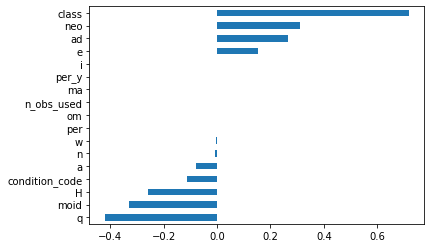

In [0]:
linRegModelo = popeline.named_steps[ 'logisticregression']
encodering = popeline.named_steps[ 'ordinalencoder']
encoderingCols = encodering.transform( xValidate).columns
coEffs = pd.Series( linRegModelo.coef_[0], encoderingCols)

coEffs.sort_values().plot.barh();

In [0]:
###     Tree-based / Random Forest model     ###

popeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier( n_estimators= 120, n_jobs= -1, random_state= 16)
)

popeline.fit( xTrain, yTrain)
yPred = popeline.predict( xValidate)
print( 'Validation accuracy: {:.5f}%'.format( accuracy_score( yValidate, yPred) *100) )

Validation accuracy: 99.99394%


In [0]:
## AGAIN?? I hope this isn't a problem with the data...

## Let's try different models..

In [11]:
###     Linear model #2: PERCEPTRON     ###

popeline = make_pipeline(
    ce.OrdinalEncoder(),
    Perceptron( n_jobs= -1, random_state= 16)
)

popeline.fit( xTrain, yTrain)
yPred = popeline.predict( xValidate)
print( 'Validation accuracy: {:.5f}%'.format( popeline.score( xValidate, yValidate) *100) )

Validation accuracy: 99.76966%


In [0]:
## Strangely/Interestingly, this is even more accurate re: the baseline. 
## Almost a perfect complement

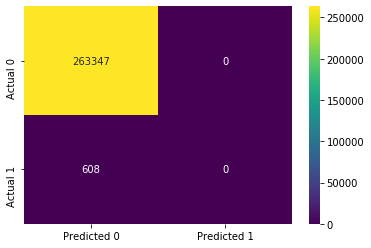

In [27]:
###     Confusion Matrix based on Perceptron results     ###
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def confuMatrixPlot( yTrue, yPred):
    labeled = unique_labels( yTrue)
    columned = [f'Predicted {label}' for label in labeled]
    indexed = [f'Actual {label}' for label in labeled]
    tabled = pd.DataFrame( confusion_matrix( yTrue, yPred),
                           columns= columned, index = indexed)
    return sns.heatmap( tabled, annot= True, fmt= 'd', cmap= 'viridis')

confuMatrixPlot( yValidate, yPred);

In [0]:
## That... that's not making any true predictions....

In [0]:
##      f1 scores      ##
##         f1,         ##
##      f1_micro,      ##
##     f1_weighted     ##
## Based on Perceptron ##

print( f1_score( yValidate, yPred))

0.0


In [0]:
print( f1_score( yValidate, yPred, average= 'micro'))

0.9976965770680608


In [0]:
print( f1_score( yValidate, yPred, average= 'weighted'))

0.9965461935708289


In [0]:
####    Let's try something completely different    ####
###       Perceptron + Precision-Recall curve        ###

classifider = make_pipeline(
    ce.OrdinalEncoder(),
    Perceptron( n_jobs= -1, random_state= 16)
)

classifider.fit( xTrain, yTrain)
yScore = classifider.decision_function( xValidate)

In [0]:
from sklearn.metrics import average_precision_score

avgPrecision = average_precision_score( yValidate, yScore)
print( 'Average precision-recall score: {0:0.5f}'.format( avgPrecision))

Average precision-recall score: 0.05596


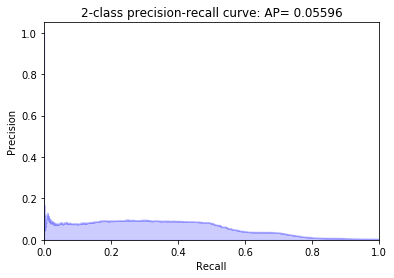

In [0]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plotPRC( title, yValidate, yScore):
    precision, recall, _ = precision_recall_curve( yValidate, yScore)
    plt.step( recall, precision, color= 'b', alpha= 0.2,
              where='post')
    plt.fill_between( recall, precision, step= 'post', alpha= 0.2, color= 'b', )

    plt.xlabel( 'Recall')
    plt.ylabel( 'Precision')
    plt.ylim( [0.0, 1.05])
    plt.xlim( [0.0, 1.0])
    plt.title( title)
    
title = ( '2-class precision-recall curve: AP= {0:0.5f}'.format( avgPrecision))

plotPRC( title, yValidate, yScore);

In [0]:
## Sooo... this is close to a no-skill classifier? As if the 100% predict 0 rate
## identified by the confusion matrix above didn't say that already....

## Maybe catboost or lightgbm would fare better?

In [0]:
#####     CATBOOST     #####

In [0]:
## For shuts n guggles, we're undoing these replacements from above (because catboost)... 

# df2[ df2.columns[ 12]] = df2[ df2.columns[ 12]].replace( {1: 'Y', 0: 'N'})
# df2[ df2.columns[ 11]] = df2[ df2.columns[ 11]].replace( {1: 'Y', 0: 'N'})

## which basically means starting over, so let's do that instead....

dfNyan = df1.dropna().copy()
dummyTrain, validate = train_test_split( dfNyan, train_size= .7, 
                                         stratify= dfNyan[ 'pha'], 
                                         random_state= 16)
train, test = train_test_split( dummyTrain, train_size= .7, 
                                stratify= dummyTrain[ 'pha'], 
                                random_state= 16)
xNyanTr = train[ features]
yNyanTr = train[ target]
xNyanVal = validate[ features]
yNyanVal = validate[ target]
xNyanTe = test[ features]
yNyanTe = test[ target]

### NOW this can be a function, lol....

In [13]:
from catboost import CatBoostClassifier

nyancat = CatBoostClassifier( depth= 10, task_type= 'GPU',
                              loss_function= 'Logloss', random_state= 16)
nyancatIndex = ['condition_code', 'neo', 'class']

nyancat.fit( xNyanTr, yNyanTr, cat_features= nyancatIndex, 
             eval_set= (xNyanVal, yNyanVal), plot= True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.147531
0:	learn: 0.2044597	test: 0.2041678	best: 0.2041678 (0)	total: 148ms	remaining: 2m 27s
1:	learn: 0.0604192	test: 0.0601132	best: 0.0601132 (1)	total: 307ms	remaining: 2m 33s
2:	learn: 0.0214755	test: 0.0213111	best: 0.0213111 (2)	total: 432ms	remaining: 2m 23s
3:	learn: 0.0101079	test: 0.0100420	best: 0.0100420 (3)	total: 536ms	remaining: 2m 13s
4:	learn: 0.0057900	test: 0.0057759	best: 0.0057759 (4)	total: 650ms	remaining: 2m 9s
5:	learn: 0.0043039	test: 0.0043567	best: 0.0043567 (5)	total: 756ms	remaining: 2m 5s
6:	learn: 0.0033707	test: 0.0034897	best: 0.0034897 (6)	total: 857ms	remaining: 2m 1s
7:	learn: 0.0029790	test: 0.0031495	best: 0.0031495 (7)	total: 956ms	remaining: 1m 58s
8:	learn: 0.0025784	test: 0.0027905	best: 0.0027905 (8)	total: 1.08s	remaining: 1m 59s
9:	learn: 0.0023559	test: 0.0025954	best: 0.0025954 (9)	total: 1.19s	remaining: 1m 57s
10:	learn: 0.0022306	test: 0.0025077	best: 0.0025077 (10)	total: 1.29s	remaining: 1m 55s
11:	learn: 0.0

In [0]:
nyanPred = nyancat.predict( xNyanVal)

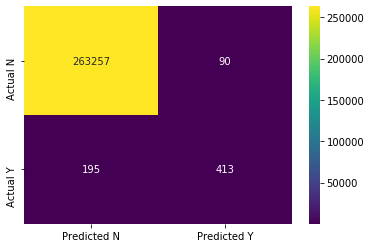

In [0]:
confuMatrixPlot( yNyanVal, nyanPred);

In [0]:
#####     THAT'S MORE LIKE IT BABY     #####

In [0]:
###     Now what does it look like on the test data?     ###

nyanPred = nyancat.predict( xNyanTe)

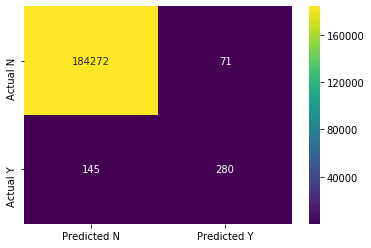

In [28]:
confuMatrixPlot( yNyanTe, nyanPred);

In [56]:
from sklearn.metrics import average_precision_score

print( 'catBoost results:')
print( '\nTest accuracy: {:.5f}%'.format( accuracy_score( yNyanTe, 
                                                        nyanPred) *100) )
print( 'Test F-score: {:.5f}'.format( f1_score( yNyanTe, nyanPred, pos_label= 'Y')) )
print( 'And weighted test F-score: {:.5f}'.format( 
       f1_score( yNyanTe, nyanPred, average= 'binary', pos_label= 'Y')) )

catBoost results:

Test accuracy: 99.88310%
Test F-score: 0.72165
And weighted test F-score: 0.72165


In [0]:
#####     LIGHTGBM     #####

In [0]:
## Some light pre-processing for LightGBM -- it can't handle strings ##

dfLight = df1.dropna().copy()
dfLight[[ 'condition_code', 'neo', 'class', 'pha']] = dfLight[[ 'condition_code', 'neo', 'class', 'pha']].astype( 'category')

dfLight[ 'condition_code'] = dfLight[ 'condition_code'].cat.codes
dfLight[ 'neo'] = dfLight[ 'neo'].cat.codes
dfLight[ 'class'] = dfLight[ 'class'].cat.codes
dfLight['pha'] = dfLight[ 'pha'].cat.codes

In [0]:
import lightgbm as lgb

# yup, rewriting this as a function could definitely (probably) be the smarter way, lol

dummyTrain, validate = train_test_split( dfLight, train_size= .7, 
                                         stratify= dfLight[ 'pha'], 
                                         random_state= 16)
train, test = train_test_split( dummyTrain, train_size= .7, 
                                stratify= dummyTrain[ 'pha'], 
                                random_state= 16)

target = 'pha'
features = train.columns.drop( [target])

xLightTr = train[ features]
yLightTr = train[ target]
xLightVal = validate[ features]
yLightVal = validate[ target]
xLightTe = test[ features]
yLightTe = test[ target]            # needed for confusion matrix, to judge efficacy of prediction

In [0]:

lightTrain = lgb.Dataset( xLightTr, label= yLightTr)
lightValidate = lightTrain.create_valid( xLightVal, label= yLightVal)

paramTrain = {
    'task': 'train',
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc'],
    'boosting': 'gbdt',
    'num_leaves': 64,
    'device_type': 'cpu',
#    'device': 'gpu',
    'gpu_use_dp': True,
    'random_state': 16,
    'is_unbalance': True
}

evalResults = {}

In [19]:

lightTrained = lgb.train( paramTrain, 
                          lightTrain, 
                          num_boost_round= 128,                 # num_iterations
                          valid_sets= [lightTrain, lightValidate], 
                          valid_names= ['train', 'valid'],
                          evals_result= evalResults
                          )


[1]	train's auc: 0.999994	train's binary_logloss: 0.019543	valid's auc: 0.997505	valid's binary_logloss: 0.0199069
[2]	train's auc: 0.23	train's binary_logloss: 0.0621526	valid's auc: 0.227112	valid's binary_logloss: 0.0635956
[3]	train's auc: 0.999906	train's binary_logloss: 0.0159429	valid's auc: 0.998252	valid's binary_logloss: 0.0151636
[4]	train's auc: 0.999904	train's binary_logloss: 0.015769	valid's auc: 0.998254	valid's binary_logloss: 0.0149956
[5]	train's auc: 0.965645	train's binary_logloss: 0.0182581	valid's auc: 0.971944	valid's binary_logloss: 0.0169381
[6]	train's auc: 0.999906	train's binary_logloss: 0.0160364	valid's auc: 0.998231	valid's binary_logloss: 0.0149591
[7]	train's auc: 0.973708	train's binary_logloss: 0.0168722	valid's auc: 0.957171	valid's binary_logloss: 0.0173237
[8]	train's auc: 0.999898	train's binary_logloss: 0.0163589	valid's auc: 0.996621	valid's binary_logloss: 0.0165591
[9]	train's auc: 0.946491	train's binary_logloss: 0.0205029	valid's auc: 0.944

In [0]:
## ROUND 1: is_unbalance= false, num_iterations= 128 ('default')

bestRound = np.argmax( evalResults[ 'valid'][ 'auc'])
trainAuc = evalResults[ 'train'][ 'auc'][ bestRound]
trainLoss = evalResults[ 'train'][ 'binary_logloss'][ bestRound]
valAuc = evalResults[ 'valid'][ 'auc'][ bestRound]
valLoss = evalResults[ 'valid'][ 'binary_logloss'][ bestRound]

print( 'Best round:', bestRound)
print( 'Training loss: {:.5f} \t\t Validation loss: {:.5f}'.format( trainLoss, valLoss))
print( 'Training AUC: {:.5f} \t\t Validation AUC: {:.5f}'.format( trainAuc, valAuc))


Best round: 0
Training loss: 0.00394 		 Validation loss: 0.00434
Training AUC: 0.99999 		 Validation AUC: 0.99913


In [20]:
## ROUND 2: is_unbalance= true, num_leaves= 64, num_iterations= 256

bestRound = np.argmax( evalResults[ 'valid'][ 'auc'])
trainAuc = evalResults[ 'train'][ 'auc'][ bestRound]
trainLoss = evalResults[ 'train'][ 'binary_logloss'][ bestRound]
valAuc = evalResults[ 'valid'][ 'auc'][ bestRound]
valLoss = evalResults[ 'valid'][ 'binary_logloss'][ bestRound]

print( 'Best round:', bestRound)
print( 'Training loss: {:.5f} \t\t Validation loss: {:.5f}'.format( trainLoss, valLoss))
print( 'Training AUC: {:.5f} \t\t Validation AUC: {:.5f}'.format( trainAuc, valAuc))


Best round: 86
Training loss: 0.05976 		 Validation loss: 0.06202
Training AUC: 0.99923 		 Validation AUC: 0.99887


In [0]:
lightPred = lightTrained.predict( xLightTe)

In [22]:
###         JUST IN CASE         ###

count = 0

for i in range(0, len( lightPred)):
    if lightPred[ i] > 0:                   #   -- if a prediction is greater than 0, but less than 1,
        if lightPred[ i] < 1:               #  _/       I want to know about it and what that proba is.
            print( lightPred[ i])           # _/
            count += 1                      # basic increment count

            if lightPred[ i] > .00001:      # setting threshold to .000001 
                lightPred[ i] = 1           # and then changing that uncertainty to a yes
            else:
                lightPred[ i] = 0           # but if it's below a .0001% chance
                                            # it should be ok to change it to a 0, for now

print( '\nTotal ruh rohs:',  count)


Total ruh rohs: 0


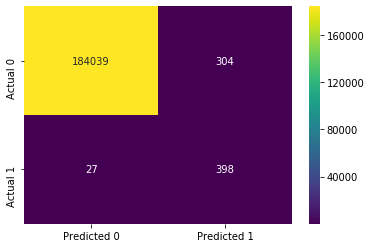

In [41]:
confuMatrixPlot( yLightTe, lightPred);

In [0]:
#####      OMG F YEAH      #####

###     It's not perfect, but only 'missing' 27 out of 729 is damn good for
###     a first run, and for its application / purpose. 
###     (it's waaaaaay better to have false positives than false negatives here)

In [55]:
from sklearn.metrics import average_precision_score

avgPrecision = average_precision_score( yLightTe, lightPred)
print( 'LightGBM results:')
print( '\nTest accuracy: {:.5f}%'.format( accuracy_score( yLightTe, 
                                                        lightPred) *100) )
print( 'Average precision-recall score: {0:0.5f}'.format( avgPrecision))
print( 'Test F-score: {:.5f}'.format( f1_score( yLightTe, lightPred)) )
print( 'And weighted test F-score: {:.5f}'.format( 
       f1_score( yLightTe, lightPred, average= 'weighted')) )

LightGBM results:

Test accuracy: 99.82086%
Average precision-recall score: 0.53108
Test F-score: 0.70630
And weighted test F-score: 0.99843


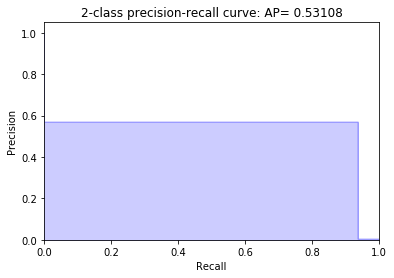

In [43]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plotPRC( title, yValidate, yScore):
    precision, recall, _ = precision_recall_curve( yValidate, yScore)
    plt.step( recall, precision, color= 'b', alpha= 0.2,
              where='post')
    plt.fill_between( recall, precision, step= 'post', alpha= 0.2, color= 'b', )

    plt.xlabel( 'Recall')
    plt.ylabel( 'Precision')
    plt.ylim( [0.0, 1.05])
    plt.xlim( [0.0, 1.0])
    plt.title( title)
    
title = ( '2-class precision-recall curve: AP= {0:0.5f}'.format( avgPrecision))

plotPRC( title, yLightTe, lightPred);